# DEEP LEARNING

In [24]:
import torch

In [25]:
torch.__version__

'2.9.1+cu130'

In [26]:
from PIL import Image
import numpy as np

In [27]:
# setting a random seed and checking if cuda is available
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [28]:
import os
from pathlib import Path

In [29]:
# checking a random image
img = Image.open(Path('data/train/curly/00cbad1ffe22d900018e5a2e7376daed4.jpg')).resize((200,200))

X = np.array(img )
X.shape

(200, 200, 3)

# DATA PREPARATION

In [30]:
# image dataset prep
from torch.utils.data import Dataset
from torchvision import transforms

In [31]:
# image preparation
class HairDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
		
		    # FOR EACH LABEL PATH
            for img_name in os.listdir(label_dir):

			    # APPEND THE PATHS OF EACH IMAGE
                self.image_paths.append(os.path.join(label_dir, img_name))

			    # APPENDING THE MAPPED INDICES AND LABELS
                self.labels.append(self.class_to_idx[label_name])

	# METHOD TO GET THE LENGTH OF EACH IMAGE PATH
    def __len__(self):
        return len(self.image_paths)

	# METHOD FOR TRANSFORMATION OF EACH IMAGE
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]


	    # BY DEFAULT NO TRANSFORMATION OCCURS AS IT IS SET TO None
        if self.transform:
            image = self.transform(image)
	
        # RETURNS THE TRANSFORMED IMAGE AND LABEL
        return image, label

In [32]:
# input image size
input_size = 200

# normalization values for rgb values after totensor transformation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# image transformations for training and test set
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

"""
# image transformations for training and test set with data augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(input_size, scale=(0.9,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
"""

'\n# image transformations for training and test set with data augmentation\ntrain_transforms = transforms.Compose([\n    transforms.RandomRotation(10),\n    transforms.RandomResizedCrop(input_size, scale=(0.9,1.0)),\n    transforms.RandomHorizontalFlip(),\n    transforms.ToTensor(),\n    transforms.Normalize(mean=mean, std=std)\n])\n\ntest_transforms = transforms.Compose([\n    transforms.Resize((input_size, input_size)),\n    transforms.ToTensor(),\n    transforms.Normalize(mean=mean, std=std)\n])\n'

In [33]:
from torch.utils.data import DataLoader

In [34]:
# loading the images
train_dataset = HairDataset(
    data_dir='./data/train',
    transform=train_transforms
)

test_dataset = HairDataset(
    data_dir='./data/test',
    transform=test_transforms
)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

In [35]:
# checking the train loader
ips, labels = next(iter(train_loader))

print(ips[0])
print()
print(labels)

tensor([[[ 0.7077,  0.7419,  0.9646,  ...,  1.3584,  1.3413,  1.3413],
         [ 0.2624,  0.5364,  0.9474,  ...,  1.3584,  1.3584,  1.3413],
         [ 0.0398,  0.2967,  0.9132,  ...,  1.3584,  1.3584,  1.3755],
         ...,
         [-1.4329, -1.3987, -1.3987,  ..., -1.4329, -1.4329, -1.4158],
         [-1.4158, -1.4158, -1.4158,  ..., -1.4329, -1.4329, -1.4329],
         [-1.4158, -1.3987, -1.4158,  ..., -1.4329, -1.4329, -1.4158]],

        [[ 0.1001,  0.1877,  0.4503,  ...,  0.7654,  0.7479,  0.7304],
         [-0.2850, -0.0049,  0.4503,  ...,  0.7654,  0.7654,  0.7304],
         [-0.4251, -0.1975,  0.4153,  ...,  0.7654,  0.7654,  0.7654],
         ...,
         [-1.4930, -1.4580, -1.4580,  ..., -1.4580, -1.4580, -1.4580],
         [-1.4755, -1.4755, -1.4755,  ..., -1.4405, -1.4580, -1.4580],
         [-1.4755, -1.4580, -1.4755,  ..., -1.4580, -1.4580, -1.4405]],

        [[ 0.1128,  0.2173,  0.4962,  ...,  0.6705,  0.6356,  0.6182],
         [-0.1835,  0.0953,  0.5311,  ...,  0

# MODEL BUILDING

In [36]:
import torch.nn as nn

In [37]:
# building a hair classifier neural net
class HairClassifier(nn.Module):
    def __init__(self):
        super(HairClassifier, self).__init__()
        
        # layer1: convoluted layer (ip 200 --> op 198)
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=0
        )
        
        # layer 1: activation function fo convoluted layer
        self.relu1 = nn.ReLU()
        
        # layer 2: pooling layer - max pool 2d (ip 198 --> op 99)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # layer 3: dense linear layer (ip 32 x 99 x 99 --> op 64)
        self.fc1 = nn.Linear(32 * 99 * 99, 64)
        
        # layer 3: activation function for dense linear layer
        self.relu2 = nn.ReLU()
        
        # layer 4: output layer binary classification dense layer (ip 64, op 1)
        self.fc2 = nn.Linear(64, 1)
        
        # self.out_activation = nn.Sigmoid() # can use sigmoid to convert logits into output if needed
    
    # forwarding the layers across 
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # flattened output from pooling fed into the dense linear layer 3
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        
        # return the model with layers 
        return x

In [38]:
# decision to send to cuda or cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [39]:
# instantiating the model prepped earlier
model = HairClassifier()

# send the model to the cuda or cpu
model.to(device)

HairClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=313632, out_features=64, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

# QUESTION 1 - Decision on binary classifier NN loss function

In [40]:
import torch.optim as optim

In [41]:
# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

# criterion
criterion = nn.BCEWithLogitsLoss()

torch.nn.BCEWithLogitsLoss() was used because the output of the hair classfier neural network is a logit output.

Outputs are raw logits because no activation fn was used in the output layer. 

So, **binary cross entropy with logits** is a suitable loss function.

# QUESTION 2 - Total number of parameters in the hair classifier neural network

In [42]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 20073473


# QUESTION 3 & 4 - Accuracy and Loss after fitting the data in the model

In [43]:
# fitting the model to the training data
num_epochs = 10
history = {'acc': [], 'loss': [], 'test_acc': [], 'test_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_epoch_loss = test_running_loss / len(test_dataset)
    test_epoch_acc = correct_test / total_test
    history['test_loss'].append(test_epoch_loss)
    history['test_acc'].append(test_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {test_epoch_loss:.4f}, Val Acc: {test_epoch_acc:.4f}")


Epoch 1/10, Loss: 0.6390, Acc: 0.6330, Val Loss: 0.6846, Val Acc: 0.5473
Epoch 2/10, Loss: 0.5586, Acc: 0.6954, Val Loss: 0.7199, Val Acc: 0.6318
Epoch 3/10, Loss: 0.5428, Acc: 0.7228, Val Loss: 0.6121, Val Acc: 0.6567
Epoch 4/10, Loss: 0.4782, Acc: 0.7615, Val Loss: 0.6065, Val Acc: 0.6766
Epoch 5/10, Loss: 0.3965, Acc: 0.8240, Val Loss: 0.6242, Val Acc: 0.6866
Epoch 6/10, Loss: 0.3455, Acc: 0.8427, Val Loss: 1.1006, Val Acc: 0.5970
Epoch 7/10, Loss: 0.3411, Acc: 0.8377, Val Loss: 0.6765, Val Acc: 0.6915
Epoch 8/10, Loss: 0.2430, Acc: 0.9014, Val Loss: 2.7641, Val Acc: 0.5323
Epoch 9/10, Loss: 0.5912, Acc: 0.7815, Val Loss: 0.6761, Val Acc: 0.6866
Epoch 10/10, Loss: 0.3609, Acc: 0.8452, Val Loss: 2.1961, Val Acc: 0.4925


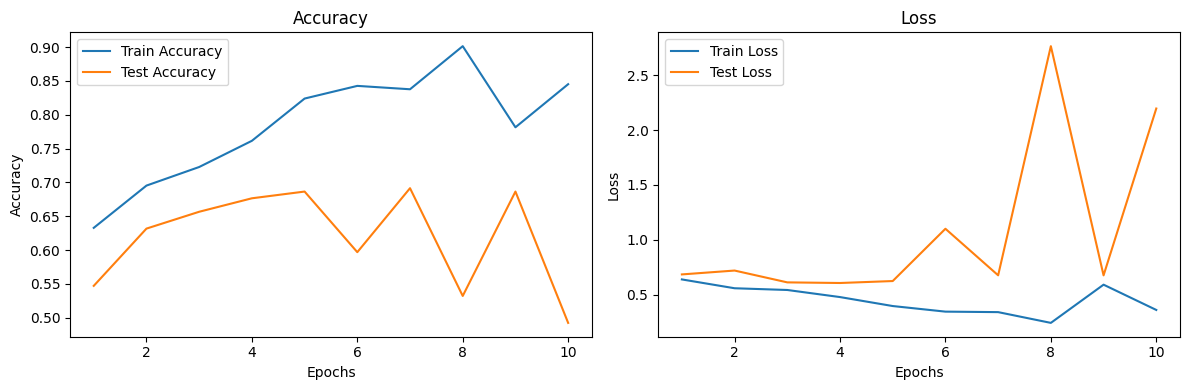

In [44]:
# plotting the outputs
import matplotlib.pyplot as plt

epochs = range(1, len(history['acc']) + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['acc'], label='Train Accuracy')
plt.plot(epochs, history['test_acc'], label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['loss'], label='Train Loss')
plt.plot(epochs, history['test_loss'], label='Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
print('Median training accuracy across 10 epochs:', np.median(history['acc']))

print('Standard deviation of training loss acrosss 10 epochs:', np.std(history['loss']))

Median training accuracy: 0.8027465667915106
Standard deviation of training loss: 0.12379260580494264
